# IADS midterm

## Part 1: Multiple choice and theoretic questions
Please write and explain your answer after each question

### Question 1. What would the p-value of 0.04 mean for t-test comparing two samples of observations (select all that applies):
A) sample averages are at least 4% different

B) sample averages are the same

C) sample averages are different

D) one can reject the null hypothesis that the samples follows the underlying distributions with the same mean at 5% significance level (or with 95% confidence) since p-values is below 0.05

E) one can't reject the null hypothesis that the samples follows the underlying distributions with the same mean at 5% significance level (or 95% confidence) singe p-value does not reach 0.05

F) one can reject the null hypothesis that the samples follows the underlying distributions with the different means at 5% significance level (or 95% confidence)

G) probability that two samples have the same means is 4%

Answer:C, D, F

### Question 2. What is true regarding normal and log-normal distributions (select all that applies):
A) Quantities following log-normal distributions have higher probabilities for extreme outliers significantly different from the mean compared to normal distributions with the same mean and standard deviation

B) Outliers significantly different from the mean are more common for the normally distributed variables compared to log normally distributed variables

C) Logarithm of the normally distributed quantity follows a log-normal distribution

D) Logarithm of the log-normally distributed quantity follows a normal distribution

E) Probability density function of the log-normally distributed variable equals to the logarithm of the probability density function of the normally distributed variable

Answer:A, D

### Question 3. What is the purpose of exploratory analysis?

A) Explore if the final outcomes of the project satisfy the requirements

B) Explore various assumptions about and patterns in the data in order to inform data curation as well as the methodology of the project

C) Explore if the research question makes sense to the stakeholders

D) Explore if the data is sufficiently clear


Answer:B

## Part 2: NYPD data analysis

In this part, you need to download New York Police Department (NYPD) complaints data for 2019 and write code for three following sections (each having own sub-sections): Data cleaning, Exploratory analysis and Hypothesis testing

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil import parser
import seaborn as sns
from scipy.stats import norm
from scipy.stats import genextreme as gev
from scipy.stats import pareto 
from scipy import stats
import geopandas as gpd
from shapely.geometry import Point
from matplotlib import pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

###  download NYPD complaints data:
two options:
1. download with curl or urllib methods
2. download with API

you can also manually download here: https://data.cityofnewyork.us/Public-Safety/NYPD-Complaint-Data-Historic/qgea-i56i

In [2]:
# !curl https://data.cityofnewyork.us/api/views/qgea-i56i/rows.csv?accessType=DOWNLOAD > NYPD_data.csv

In [3]:
# !wget https://data.cityofnewyork.us/api/views/qgea-i56i/rows.csv?accessType=DOWNLOAD

### read data

In [4]:
data = pd.read_csv('NYPD_data.csv')
data.head()

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,...,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX
0,10600119,01/01/2002,11:00:00,02/25/2006,11:00:00,NaN,03/06/2006,104,RAPE,157.0,...,M,NaN,NaN,NaN,NaN,(null),(null),18-24,WHITE,F
1,11052575,04/22/2005,02:00:00,NaN,(null),NaN,04/22/2006,110,GRAND LARCENY OF MOTOR VEHICLE,441.0,...,(null),NaN,NaN,NaN,NaN,(null),(null),25-44,BLACK,M
2,10832306,07/11/2005,20:00:00,03/29/2006,12:00:00,NaN,03/29/2006,353,UNAUTHORIZED USE OF A VEHICLE,462.0,...,M,NaN,NaN,NaN,NaN,(null),(null),45-64,WHITE,M
3,10107192,10/19/2005,20:30:00,NaN,(null),NaN,01/13/2006,126,MISCELLANEOUS PENAL LAW,461.0,...,F,NaN,NaN,NaN,NaN,(null),(null),25-44,BLACK,F
4,23893731,12/04/2005,09:00:00,08/09/2006,17:00:00,NaN,08/09/2006,109,GRAND LARCENY,405.0,...,(null),NaN,NaN,NaN,NaN,(null),(null),25-44,WHITE,F


In [5]:
data.shape

(8353049, 35)

In [6]:
data.columns

Index(['CMPLNT_NUM', 'CMPLNT_FR_DT', 'CMPLNT_FR_TM', 'CMPLNT_TO_DT',
       'CMPLNT_TO_TM', 'ADDR_PCT_CD', 'RPT_DT', 'KY_CD', 'OFNS_DESC', 'PD_CD',
       'PD_DESC', 'CRM_ATPT_CPTD_CD', 'LAW_CAT_CD', 'BORO_NM',
       'LOC_OF_OCCUR_DESC', 'PREM_TYP_DESC', 'JURIS_DESC', 'JURISDICTION_CODE',
       'PARKS_NM', 'HADEVELOPT', 'HOUSING_PSA', 'X_COORD_CD', 'Y_COORD_CD',
       'SUSP_AGE_GROUP', 'SUSP_RACE', 'SUSP_SEX', 'TRANSIT_DISTRICT',
       'Latitude', 'Longitude', 'Lat_Lon', 'PATROL_BORO', 'STATION_NAME',
       'VIC_AGE_GROUP', 'VIC_RACE', 'VIC_SEX'],
      dtype='object')

The complete data dictionary is here: https://data.cityofnewyork.us/api/views/qgea-i56i/files/b21ec89f-4d7b-494e-b2e9-f69ae7f4c228?download=true&filename=NYPD_Complaint_Incident_Level_Data_Footnotes.pdf. 

The focus of this notebook would be on following columns - 'CMPLNT_NUM', 'CMPLNT_FR_DT', 'CMPLNT_FR_TM', 'OFNS_DESC', 'BORO_NM', 'PARKS_NM', 'Latitude', 'Longitude'.

The 'CMPLNT_NUM' is a unique id for each complaint, 'CMPLNT_FR_DT' and 'CMPLNT_FR_TM' are date and time of complaint respectively, 'OFNS_DESC' is the type of offence reported, 'BORO_NM' is name of borough where complaint was reported, 'PARKS_NM' is name of park where complaint recorded (if any) and 'Latitude', 'Longitude' are location of complaint.


## Section 1 - Data cleaning tasks
1. Drop rows with a) missing/wrong complaint date and time b) missing borough name and c) duplicate complaint number ('CMPLNT_NUM' column)
2. Filter out data where incident occured in a park or greenspace. Next, keep data for 2019 and after.
3. Keep specific crime categories - type 1 crimes defined by FBI: The list is given here https://ucr.fbi.gov/crime-in-the-u.s/2011/crime-in-the-u.s.-2011/offense-definitions
4. Filter by area (drop rows with location outside NYC)

Note on Plotting: When creating plots, please make sure to include all necessary elements such as legends, axis labels, and titles to make your graphs easily understandable. Properly labeled plots are crucial for conveying your findings clearly and will be considered in the grading.

### 1. filter out missing/wrong date and times, missing borough name and duplicate complaints from the data

In [7]:
# code here 
# make sure to convert date column to datetime

In [8]:
#a
data['CMPLNT_FR_DT'] = pd.to_datetime(data['CMPLNT_FR_DT'], errors='coerce')
data['CMPLNT_FR_TM'] = pd.to_datetime(data['CMPLNT_FR_TM'], format='%H:%M:%S',errors='coerce')
data = data.dropna(subset=['CMPLNT_FR_DT', 'CMPLNT_FR_TM'])

In [9]:
#b
data = data.dropna(subset=['BORO_NM'])

In [10]:
data['BORO_NM'].unique()

array(['MANHATTAN', 'BRONX', 'BROOKLYN', 'QUEENS', 'STATEN ISLAND',
       '(null)'], dtype=object)

In [11]:
data = data[data['BORO_NM'] != '(null)']

In [12]:
data['BORO_NM'].unique()

array(['MANHATTAN', 'BRONX', 'BROOKLYN', 'QUEENS', 'STATEN ISLAND'],
      dtype=object)

In [13]:
#c
data = data.drop_duplicates(subset=['CMPLNT_NUM'])

In [14]:
data.shape

(8345414, 35)

### 2. Remove rows where location is parks or greenspace and keep rows for 2019 and after

In [15]:
# parks name is in 'PARKS_NM' column. If a crime has occured outside a parkspace, this value would be NaN
data=data[(data['PARKS_NM']== str('(null)'))|pd.isna(data['PARKS_NM'])]


In [16]:
## check the timeline of data
min_date = data['CMPLNT_FR_DT'].min()
max_date = data['CMPLNT_FR_DT'].max()
print(f"Data starts on {min_date} and ends on {max_date}")

Data starts on 1900-03-10 00:00:00 and ends on 2022-12-31 00:00:00


In [17]:
# remove data <2019
start2019=pd.to_datetime('1/1/2019')
data = data[data['CMPLNT_FR_DT'] >= start2019]


In [18]:
data.shape

(1826692, 35)

### 3. keep type 1 crimes as defined by FBI from the data : 
https://ucr.fbi.gov/crime-in-the-u.s/2011/crime-in-the-u.s.-2011/offense-definitions

The crime type is present in the 'OFNS_DESC' column. You just need to keep the following categories: "'ARSON', 'BURGLARY', 'FELONY ASSAULT', 'GRAND LARCENY' ,'GRAND LARCENY OF MOTOR VEHICLE',
                'MURDER & NON-NEGL. MANSLAUGHTER', 'RAPE', 'ROBBERY'"

In [19]:
# code here
data=data.loc[data['OFNS_DESC'].isin(['ARSON', 'BURGLARY', 'FELONY ASSAULT', 'GRAND LARCENY' ,'GRAND LARCENY OF MOTOR VEHICLE', 'MURDER & NON-NEGL. MANSLAUGHTER', 'RAPE', 'ROBBERY'])]


### 4. keep rows with location within NYC

zip codes file is present in the github 'Data' repository as "ZIPCODE.zip". You can also download the shapefile here: https://data.cityofnewyork.us/Business/Zip-Code-Boundaries/i8iw-xf4u/data?no_mobile=true .

Do a spatial joint to keep only rows within NYC

Check if lat-long is within one of the five county zip code shapes

Hint: You might want to try gpd.sjoin with , op='within', how='inner'  with the geopandas dataframe containing all such zip code areas

In [20]:
## zip codes map
zips = gpd.read_file('ZIP_CODE_040114/ZIP_CODE_040114.shp')
zips.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.252 188138.380, 1038141.936 ..."
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.713 186926.440, 1002314.243 ..."
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.276 183696.338, 1011373.584 ..."
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.365 183617.613, 996522.848 18..."
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.113 176307.496, 992042.798 17..."


Note: 'ZIPCODE' column has unique codes. The borough name is given in 'COUNTY' column. The counties and boroughs are synonymous in NYC. 'New York' county corresponds to Manhattan, 'Kings' to Brooklyn, 'Richmond' to Staten Island

In [21]:
zips.COUNTY.unique()

array(['Queens', 'Kings', 'Bronx', 'New York', 'Richmond'], dtype=object)

<AxesSubplot:>

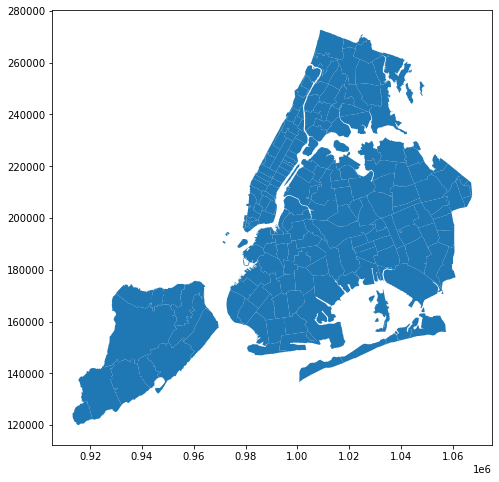

In [22]:
zips.plot(figsize=(8,8))

In [23]:
# remove rows with location outside NYC
data['BORO_NM'].unique()

array(['BROOKLYN', 'MANHATTAN', 'BRONX', 'QUEENS', 'STATEN ISLAND'],
      dtype=object)

In [24]:
zips=zips.replace({'COUNTY':{'New York':'MANHATTAN','Queens':'QUEENS','Bronx':'BRONX','Kings':'BROOKLYN','Richmond':'STATEN ISLAND'}})

In [25]:
dgeometry = gpd.points_from_xy(data['Longitude'],data['Latitude'])
data_geo = gpd.GeoDataFrame(data, geometry=dgeometry)

In [26]:
print(data_geo.crs)

None


In [27]:
zips.to_crs(epsg=4326, inplace=True)
zips

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,QUEENS,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.80585 40.68291, -73.80569 40.682..."
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,BROOKLYN,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.93740 40.67973, -73.93487 40.679..."
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,BROOKLYN,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.90294 40.67084, -73.90223 40.668..."
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,BROOKLYN,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.95797 40.67066, -73.95576 40.670..."
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,BROOKLYN,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.97208 40.65060, -73.97192 40.650..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,10310,0,Staten Island,25003.0,5.346328e+07,NY,STATEN ISLAND,36,085,http://www.usps.com/,0.0,0.0,"POLYGON ((-74.12065 40.64104, -74.12057 40.641..."
259,11693,0,Far Rockaway,11052.0,3.497516e+06,NY,BROOKLYN,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.84076 40.62536, -73.84306 40.627..."
260,11249,0,Brooklyn,28481.0,1.777221e+07,NY,BROOKLYN,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.95805 40.72442, -73.95772 40.724..."
261,10162,1,New York,0.0,2.103489e+04,NY,MANHATTAN,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.95133 40.76931, -73.95165 40.769..."


In [28]:
data_geo.set_crs(epsg=4326, inplace=True)

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,...,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,geometry
81,206878965,2019-12-30,1900-01-01 13:30:00,12/30/2019,14:00:00,73.0,12/30/2019,105,ROBBERY,387.0,...,NaN,40.671130,-73.913502,"(40.6711300016904, -73.9135020552048)",PATROL BORO BKLYN NORTH,(null),<18,BLACK,M,POINT (-73.91350 40.67113)
82,206890929H1,2019-12-31,1900-01-01 23:15:00,NaN,(null),28.0,12/31/2019,101,MURDER & NON-NEGL. MANSLAUGHTER,NaN,...,NaN,40.808418,-73.952474,"(40.8084177460021, -73.9524740603515)",PATROL BORO MAN NORTH,(null),25-44,BLACK,M,POINT (-73.95247 40.80842)
85,213858183,2020-05-28,1900-01-01 08:15:00,NaN,(null),43.0,05/28/2020,107,BURGLARY,231.0,...,NaN,40.822912,-73.870041,"(40.8229123084767, -73.8700413043181)",PATROL BORO BRONX,(null),UNKNOWN,UNKNOWN,D,POINT (-73.87004 40.82291)
91,221596870,2020-12-05,1900-01-01 15:00:00,NaN,(null),33.0,12/08/2020,104,RAPE,157.0,...,NaN,40.840781,-73.936245,"(40.8407811088581, -73.9362453818218)",PATROL BORO MAN NORTH,(null),<18,BLACK,F,POINT (-73.93625 40.84078)
94,224774734,2021-02-22,1900-01-01 14:22:00,NaN,(null),41.0,02/24/2021,114,ARSON,264.0,...,NaN,40.804008,-73.878333,"(40.804008, -73.878333)",PATROL BORO BRONX,(null),UNKNOWN,UNKNOWN,E,POINT (-73.87833 40.80401)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8353025,261180746,2022-12-31,1900-01-01 22:00:00,12/31/2022,22:20:00,18.0,12/31/2022,106,FELONY ASSAULT,106.0,...,NaN,40.763545,-73.985192,"(40.76354467, -73.98519221)",PATROL BORO MAN SOUTH,(null),18-24,WHITE,L,POINT (-73.98519 40.76354)
8353032,261161441,2022-12-31,1900-01-01 03:00:00,12/31/2022,06:00:00,14.0,12/31/2022,109,GRAND LARCENY,408.0,...,4.0,40.751442,-73.976049,"(40.75144155, -73.9760491)",PATROL BORO MAN SOUTH,42 ST.-GRAND CENTRAL,45-64,WHITE HISPANIC,M,POINT (-73.97605 40.75144)
8353033,261173446,2022-12-31,1900-01-01 15:00:00,12/31/2022,15:30:00,79.0,12/31/2022,105,ROBBERY,388.0,...,NaN,40.698304,-73.953147,"(40.698304, -73.953147)",PATROL BORO BKLYN NORTH,(null),18-24,WHITE HISPANIC,M,POINT (-73.95315 40.69830)
8353040,261152819,2022-12-30,1900-01-01 09:00:00,12/30/2022,20:30:00,109.0,12/30/2022,107,BURGLARY,221.0,...,NaN,40.792606,-73.844008,"(40.792606, -73.844008)",PATROL BORO QUEENS NORTH,(null),25-44,ASIAN / PACIFIC ISLANDER,M,POINT (-73.84401 40.79261)


In [29]:
data_geo.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [30]:
zips.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [31]:
df=gpd.sjoin(data_geo,zips, how='inner', op='within')

In [32]:
df

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,...,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN
81,206878965,2019-12-30,1900-01-01 13:30:00,12/30/2019,14:00:00,73.0,12/30/2019,105,ROBBERY,387.0,...,Brooklyn,66737.0,3.787169e+07,NY,BROOKLYN,36,047,http://www.usps.com/,0.0,0.0
6509575,191782128,2019-01-02,1900-01-01 14:00:00,01/02/2019,14:55:00,73.0,01/02/2019,106,FELONY ASSAULT,109.0,...,Brooklyn,66737.0,3.787169e+07,NY,BROOKLYN,36,047,http://www.usps.com/,0.0,0.0
6509726,191914830,2019-01-05,1900-01-01 17:22:00,01/05/2019,17:25:00,73.0,01/05/2019,105,ROBBERY,392.0,...,Brooklyn,66737.0,3.787169e+07,NY,BROOKLYN,36,047,http://www.usps.com/,0.0,0.0
6510050,191916242,2019-01-05,1900-01-01 01:30:00,NaN,(null),73.0,01/05/2019,106,FELONY ASSAULT,105.0,...,Brooklyn,66737.0,3.787169e+07,NY,BROOKLYN,36,047,http://www.usps.com/,0.0,0.0
6510271,191724936,2019-01-01,1900-01-01 13:30:00,01/01/2019,13:35:00,73.0,01/01/2019,106,FELONY ASSAULT,105.0,...,Brooklyn,66737.0,3.787169e+07,NY,BROOKLYN,36,047,http://www.usps.com/,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8228320,252323497,2022-10-10,1900-01-01 19:47:00,10/10/2022,19:55:00,115.0,10/10/2022,106,FELONY ASSAULT,106.0,...,Flushing,0.0,3.055847e+07,NY,QUEENS,36,081,http://www.usps.com/,0.0,0.0
8280108,254132433,2022-11-12,1900-01-01 15:45:00,NaN,(null),115.0,11/14/2022,109,GRAND LARCENY,439.0,...,Flushing,0.0,3.055847e+07,NY,QUEENS,36,081,http://www.usps.com/,0.0,0.0
7915512,246084243,2022-02-28,1900-01-01 15:00:00,04/18/2022,10:40:00,114.0,06/03/2022,110,GRAND LARCENY OF MOTOR VEHICLE,441.0,...,Bronx,40591.0,1.819021e+07,NY,BRONX,36,005,http://www.usps.com/,0.0,0.0
8105838,248224815,2022-07-19,1900-01-01 10:19:00,07/19/2022,10:20:00,1.0,07/19/2022,106,FELONY ASSAULT,109.0,...,New York,0.0,7.711145e+04,NY,MANHATTAN,36,061,http://www.usps.com/,0.0,0.0


In [33]:
df = df.drop_duplicates(subset=['CMPLNT_NUM'])# remove the repeat rows.

In [34]:
df

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,...,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN
81,206878965,2019-12-30,1900-01-01 13:30:00,12/30/2019,14:00:00,73.0,12/30/2019,105,ROBBERY,387.0,...,Brooklyn,66737.0,3.787169e+07,NY,BROOKLYN,36,047,http://www.usps.com/,0.0,0.0
6509575,191782128,2019-01-02,1900-01-01 14:00:00,01/02/2019,14:55:00,73.0,01/02/2019,106,FELONY ASSAULT,109.0,...,Brooklyn,66737.0,3.787169e+07,NY,BROOKLYN,36,047,http://www.usps.com/,0.0,0.0
6509726,191914830,2019-01-05,1900-01-01 17:22:00,01/05/2019,17:25:00,73.0,01/05/2019,105,ROBBERY,392.0,...,Brooklyn,66737.0,3.787169e+07,NY,BROOKLYN,36,047,http://www.usps.com/,0.0,0.0
6510050,191916242,2019-01-05,1900-01-01 01:30:00,NaN,(null),73.0,01/05/2019,106,FELONY ASSAULT,105.0,...,Brooklyn,66737.0,3.787169e+07,NY,BROOKLYN,36,047,http://www.usps.com/,0.0,0.0
6510271,191724936,2019-01-01,1900-01-01 13:30:00,01/01/2019,13:35:00,73.0,01/01/2019,106,FELONY ASSAULT,105.0,...,Brooklyn,66737.0,3.787169e+07,NY,BROOKLYN,36,047,http://www.usps.com/,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8207799,251196892,2022-09-16,1900-01-01 17:01:00,09/16/2022,17:11:00,115.0,09/16/2022,110,GRAND LARCENY OF MOTOR VEHICLE,441.0,...,Flushing,0.0,3.055847e+07,NY,QUEENS,36,081,http://www.usps.com/,0.0,0.0
8228320,252323497,2022-10-10,1900-01-01 19:47:00,10/10/2022,19:55:00,115.0,10/10/2022,106,FELONY ASSAULT,106.0,...,Flushing,0.0,3.055847e+07,NY,QUEENS,36,081,http://www.usps.com/,0.0,0.0
8280108,254132433,2022-11-12,1900-01-01 15:45:00,NaN,(null),115.0,11/14/2022,109,GRAND LARCENY,439.0,...,Flushing,0.0,3.055847e+07,NY,QUEENS,36,081,http://www.usps.com/,0.0,0.0
7915512,246084243,2022-02-28,1900-01-01 15:00:00,04/18/2022,10:40:00,114.0,06/03/2022,110,GRAND LARCENY OF MOTOR VEHICLE,441.0,...,Bronx,40591.0,1.819021e+07,NY,BRONX,36,005,http://www.usps.com/,0.0,0.0


<AxesSubplot:>

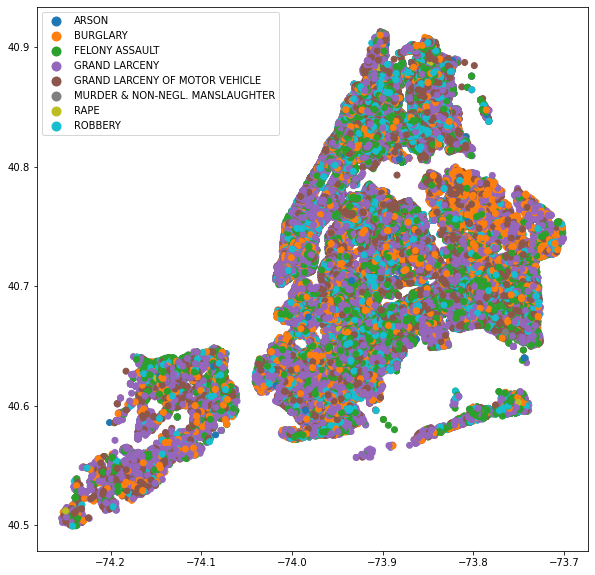

In [35]:
df.plot(figsize=(10,10), column='OFNS_DESC', legend=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


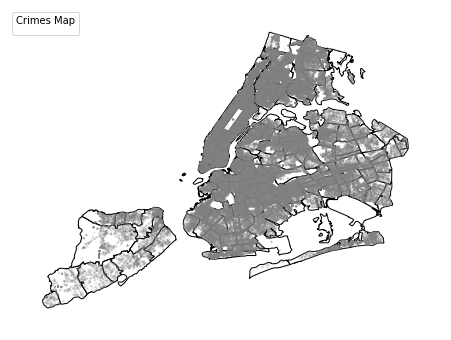

In [36]:
import geoplot as gplt
ax = gplt.polyplot(df=zips)
 
ax = gplt.pointplot(df=df,
                    s=2,
                    color='grey',
                    alpha=0.2,
                    linewidth=0,
                    ax=ax)
ax.legend(loc="upper left", title="Crimes Map")

In [37]:
df.columns

Index(['CMPLNT_NUM', 'CMPLNT_FR_DT', 'CMPLNT_FR_TM', 'CMPLNT_TO_DT',
       'CMPLNT_TO_TM', 'ADDR_PCT_CD', 'RPT_DT', 'KY_CD', 'OFNS_DESC', 'PD_CD',
       'PD_DESC', 'CRM_ATPT_CPTD_CD', 'LAW_CAT_CD', 'BORO_NM',
       'LOC_OF_OCCUR_DESC', 'PREM_TYP_DESC', 'JURIS_DESC', 'JURISDICTION_CODE',
       'PARKS_NM', 'HADEVELOPT', 'HOUSING_PSA', 'X_COORD_CD', 'Y_COORD_CD',
       'SUSP_AGE_GROUP', 'SUSP_RACE', 'SUSP_SEX', 'TRANSIT_DISTRICT',
       'Latitude', 'Longitude', 'Lat_Lon', 'PATROL_BORO', 'STATION_NAME',
       'VIC_AGE_GROUP', 'VIC_RACE', 'VIC_SEX', 'geometry', 'index_right',
       'ZIPCODE', 'BLDGZIP', 'PO_NAME', 'POPULATION', 'AREA', 'STATE',
       'COUNTY', 'ST_FIPS', 'CTY_FIPS', 'URL', 'SHAPE_AREA', 'SHAPE_LEN'],
      dtype='object')

In [38]:
ndf=df[['ZIPCODE','OFNS_DESC']].groupby(by='ZIPCODE', as_index=False).count()
ndf.rename(columns={'OFNS_DESC':'cbzNumber'}, inplace=True)

In [39]:
ndfmap=zips.merge(ndf,left_on='ZIPCODE',right_on='ZIPCODE')

In [40]:
ndfmap.crs
#zips.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [41]:
ndfmap['cbzDensity']=ndfmap['cbzNumber']/ndfmap['AREA']

<AxesSubplot:>

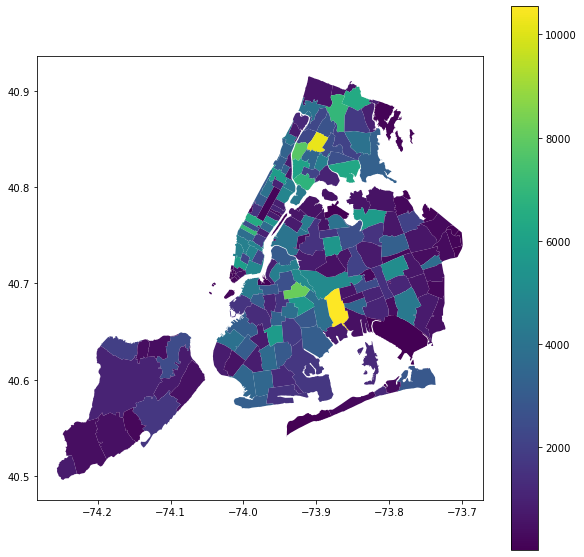

In [42]:
ndfmap.plot(figsize=(10,10),column='cbzNumber',legend=True)#the number of CMPLNT per ZIPCODE zone

<AxesSubplot:>

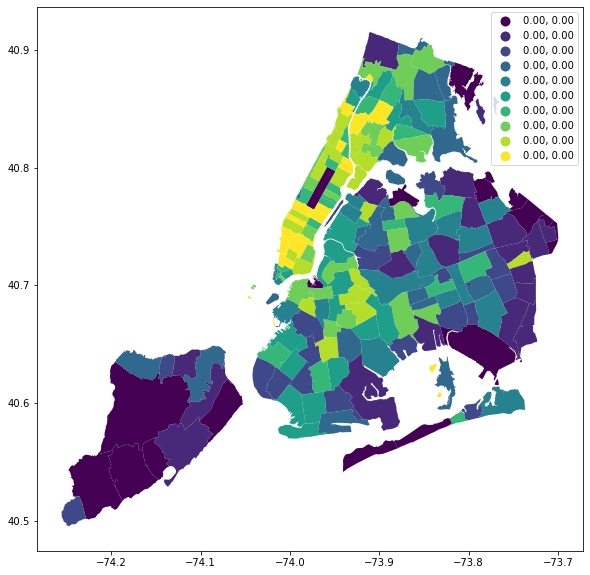

In [43]:
ndfmap.plot(figsize=(10,10),column='cbzDensity',k=10,scheme='Quantiles',legend=True)#the density of CMPLNT per ZIPCODE zone

## Section 2 -Exploratory analysis tasks

1. Visualize the time series of the total number of type 1 crimes for the whole city per day.
2. Visualize type 1 crimes grouped on a) borough level as a bar plot and b) zip code level as a heatmap normalized by population (per 100,000). Use quantiles scheme colormap.
3. Plot following bar plots: the total number of type 1 crimes by a) month, b) day of week( use weekday names for labels) and c) hour of day.
4. Plot two bar plots: Day of the week and hour of the day timelines for felony vs grand larceny (normalized per 100,000 population, comparing these two types of crime on the same bar plots)
5. Compare the %% decomposition of type 1 crimes by category of crime within different boroughs by plotting pie charts for each borough


### 1. time series plotting

In [44]:
# group total crimes by daily numbers
cbdn=data[['CMPLNT_FR_DT','CMPLNT_NUM']].groupby(by='CMPLNT_FR_DT').count()

<AxesSubplot:xlabel='CMPLNT_FR_DT'>

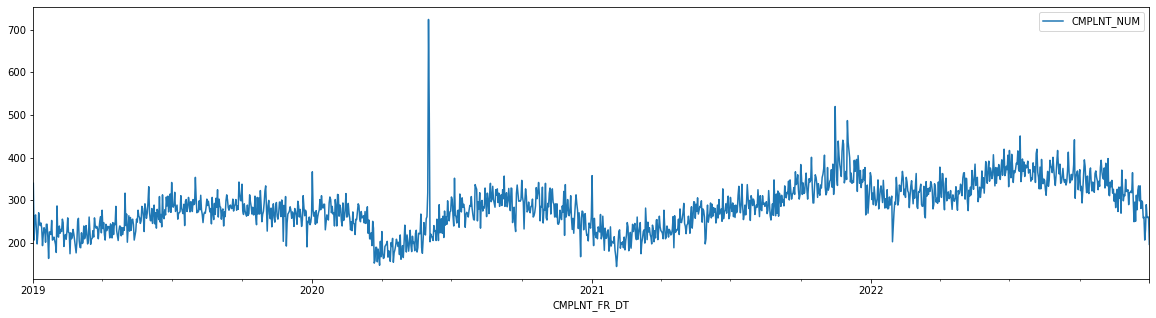

In [45]:
# plot as a time series
cbdn.plot(figsize=(20,5))

### 2. plotting on borough and zip code level normalized by population

In [46]:
# group crime numbers by borough and normalize by their population (per 100,000). Population is given in the zips shapefile
cbb=df[['BORO_NM','CMPLNT_NUM']].groupby(by='BORO_NM', as_index=False).count()
zbb=zips.groupby(['COUNTY']).agg({'POPULATION':'sum'}).reset_index()
pbb=zbb[['COUNTY','POPULATION']].groupby(by='COUNTY', as_index=False).sum()
dfbb=cbb.merge(pbb,left_on='BORO_NM',right_on='COUNTY')
dfbb['cbbnbp']=dfbb['CMPLNT_NUM']/dfbb['POPULATION']*100000

In [47]:
pbb

,COUNTY,POPULATION
0,BRONX,1431301.0
1,BROOKLYN,2548896.0
2,MANHATTAN,1687421.0
3,QUEENS,2262768.0
4,STATEN ISLAND,468220.0


<AxesSubplot:xlabel='COUNTY'>

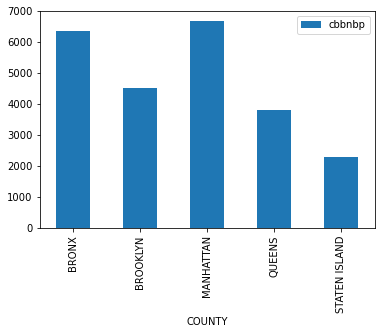

In [48]:
# plot as a bar plot
dfbb.plot.bar(x='COUNTY',y='cbbnbp')

In [49]:
# now group by zip codes, normalize by their population
dfbz=df[['ZIPCODE','CMPLNT_NUM']].groupby(by='ZIPCODE', as_index=False).count()
dfbp=zips[['ZIPCODE','POPULATION']]
dfbzbp=dfbz.merge(dfbp,left_on='ZIPCODE',right_on='ZIPCODE')
dfbzbp['cbzcbp']=dfbzbp['CMPLNT_NUM']/dfbzbp['POPULATION']*100000
dfbzbpmap=zips.merge(dfbzbp,left_on='ZIPCODE',right_on='ZIPCODE')

<AxesSubplot:>

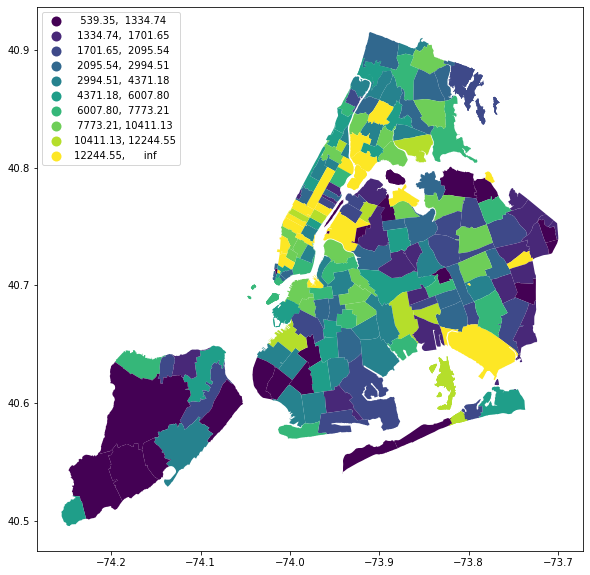

In [50]:
# plot as a heatmap with quantiles color scheme
dfbzbpmap.plot(figsize=(10,10),column='cbzcbp',k=10,scheme='Quantiles',legend=True,legend_kwds={'loc': 'upper left'})

### 3. bar plots of total type 1 crimes vs a) months b) day of week and c) hour of day

In [51]:
# code here
df['month']=df['CMPLNT_FR_DT'].dt.month
df['DOW']=df['CMPLNT_FR_DT'].dt.dayofweek
df['HOD']=df['CMPLNT_FR_TM'].dt.hour

In [52]:
CBM=df[['month','CMPLNT_NUM']].groupby(by='month',as_index=False).count()
CBDOW=df[['DOW','CMPLNT_NUM']].groupby(by='DOW',as_index=False).count()
CBHOD=df[['HOD','CMPLNT_NUM']].groupby(by='HOD',as_index=False).count()

<AxesSubplot:title={'center':'CBM'}, xlabel='month'>

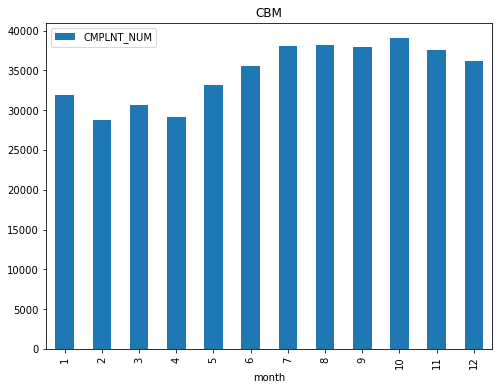

In [53]:
CBM.plot.bar(figsize=(8, 6),y='CMPLNT_NUM',x='month',title='CBM')#xlable is month,0-11 is the month Jan to Dec

<AxesSubplot:title={'center':'CBDOW'}, xlabel='DOW'>

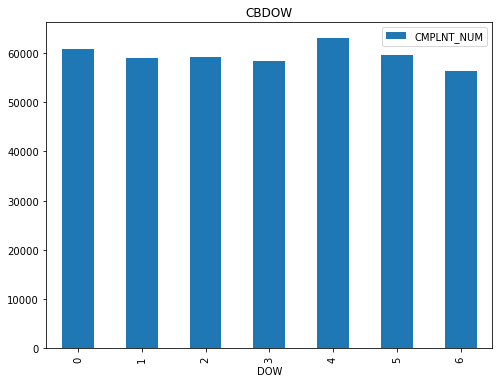

In [54]:
CBDOW.plot.bar(figsize=(8, 6),x='DOW',y='CMPLNT_NUM',title='CBDOW')#xlable is day of week,0-6 is the day of week Monday to Sunday

<AxesSubplot:title={'center':'CBHOD'}, xlabel='HOD'>

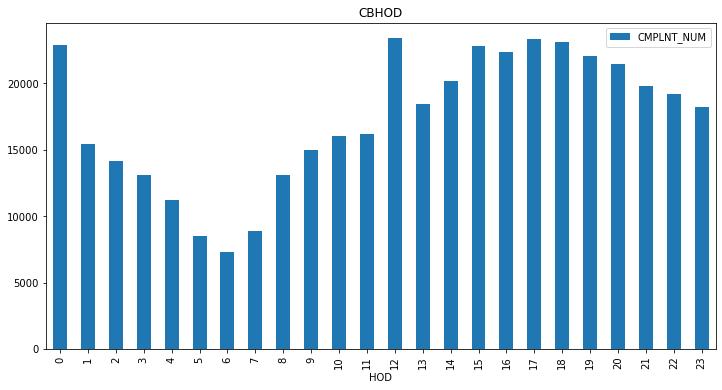

In [55]:
CBHOD.plot.bar(figsize=(12, 6),x='HOD',y='CMPLNT_NUM',title='CBHOD')#xlable is HOD,0-23 is the hours

### 4. Bar plots: Felony assault vs grand larceny grouped by a) day of week and b) hour of day

In [56]:
# filter data for above crime types
FAGLdf=df.loc[df['OFNS_DESC'].isin(['FELONY ASSAULT', 'GRAND LARCENY'])]

In [57]:
# group the numbers and normalize by total city population (per 100,000)
g1=FAGLdf.groupby(['DOW','OFNS_DESC']).agg({'CMPLNT_NUM':'count'}).reset_index()
g2=FAGLdf.groupby(['HOD','OFNS_DESC']).agg({'CMPLNT_NUM':'count'}).reset_index()
Pop=zips['POPULATION'].sum()
g1['nbp']=g1['CMPLNT_NUM']/Pop*100000
g2['nbp']=g2['CMPLNT_NUM']/Pop*100000

In [58]:
g1

,DOW,OFNS_DESC,CMPLNT_NUM,nbp
0,0,FELONY ASSAULT,12262,146.000420
1,0,GRAND LARCENY,25217,300.252209
2,1,FELONY ASSAULT,11680,139.070698
3,1,GRAND LARCENY,24648,293.477275
4,2,FELONY ASSAULT,11980,142.642720
5,2,GRAND LARCENY,24855,295.941969
6,3,FELONY ASSAULT,11729,139.654128
7,3,GRAND LARCENY,24276,289.047968
8,4,FELONY ASSAULT,12674,150.905996
9,4,GRAND LARCENY,26220,312.194667


In [59]:
# plot two bar plots: one for day of week and other for hour of day
# each plot should have comparison of the two type of crime numbers (normalized) by weekday and hour respectively

FA1=g1.loc[g1['OFNS_DESC'].isin(['FELONY ASSAULT'])]
GL1=g1.loc[g1['OFNS_DESC'].isin(['GRAND LARCENY'])]
FA2=g2.loc[g2['OFNS_DESC'].isin(['FELONY ASSAULT'])]
GL2=g2.loc[g2['OFNS_DESC'].isin(['GRAND LARCENY'])]

In [60]:
fa1=list(FA1['nbp'])
gl1=list(GL1['nbp'])
fa2=list(FA2['nbp'])
gl2=list(GL2['nbp'])

In [61]:
label1=g1['DOW']
label2=g2['HOD']

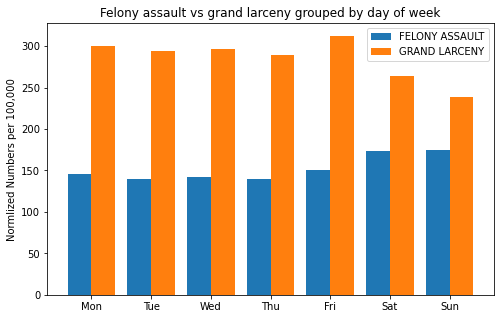

In [62]:
#a
x = np.arange(len(label1)/2)
width = 0.4
fig, ax = plt.subplots(figsize=(8,5))
rects1 = ax.bar(x - width/2, fa1, width, label='FELONY ASSAULT')
rects2 = ax.bar(x + width/2, gl1, width, label='GRAND LARCENY')
ax.set_ylabel('Normlized Numbers per 100,000')
ax.set_title('Felony assault vs grand larceny grouped by day of week')
ax.set_xticks(x)
ax.set_xticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
ax.legend()

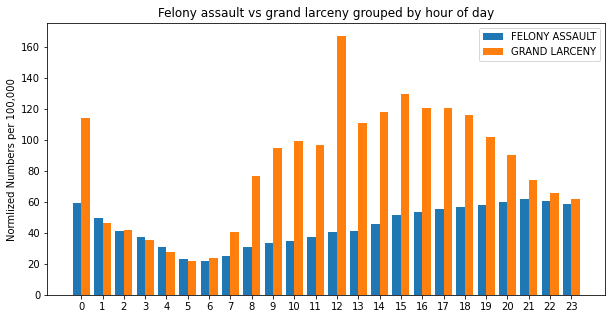

In [63]:
#b
x = np.arange(len(label2)/2)
width = 0.4
fig, ax = plt.subplots(figsize=(10, 5))
rects1 = ax.bar(x - width/2, fa2, width, label='FELONY ASSAULT')
rects2 = ax.bar(x + width/2, gl2, width, label='GRAND LARCENY')
ax.set_ylabel('Normlized Numbers per 100,000')
ax.set_title('Felony assault vs grand larceny grouped by hour of day')
ax.set_xticks(x)
ax.set_xticklabels(range(24))
ax.legend()

### 5. comparing the %% decomposition of type 1 crimes by category of crime

for matplotlib pie charts documentation: https://matplotlib.org/3.1.1/gallery/pie_and_polar_charts/pie_features.html

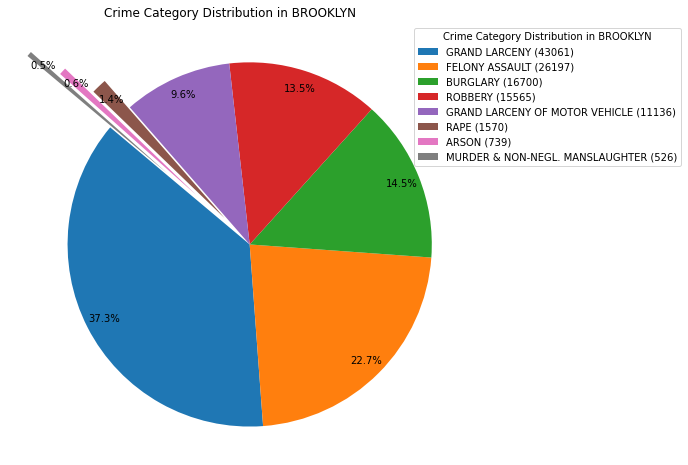

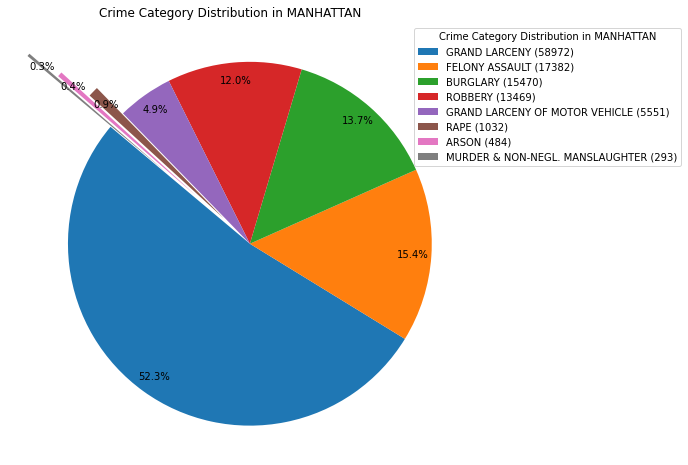

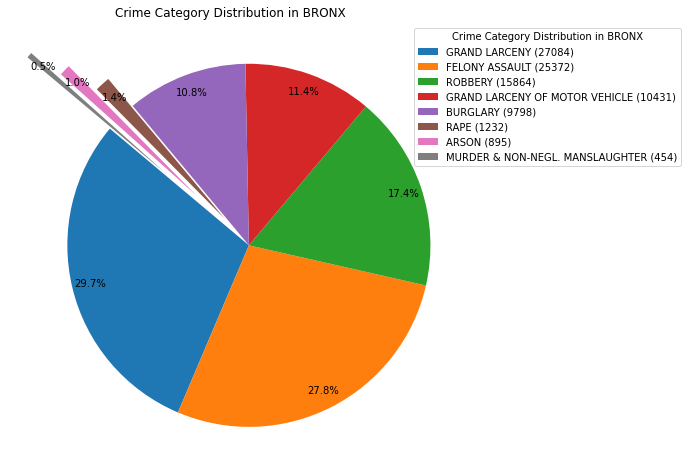

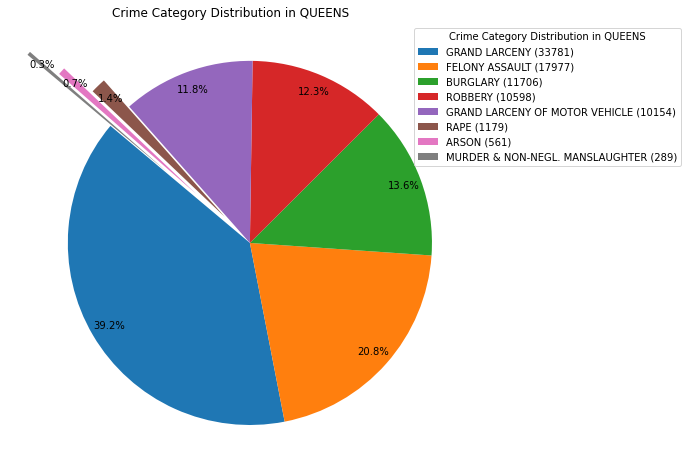

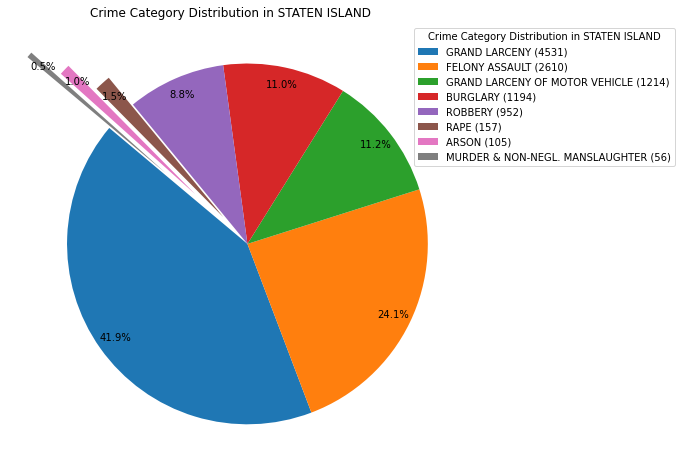

In [64]:
# plot 5 pie charts for each borough depicting % of each crime type within type 1 crimes

for boro in df.BORO_NM.unique():
    borough_data = df[df['BORO_NM'] == boro]
    
    ccc = borough_data['OFNS_DESC'].value_counts()
    
    # Plot the pie chart
    plt.figure(figsize=(8,8))
    plt.pie(ccc, labels=None, autopct='%1.1f%%',pctdistance=0.9, startangle=140,explode=(0,0,0,0,0,0.2,0.4,0.6))
    plt.axis('equal')
    plt.title(f'Crime Category Distribution in {boro}')
    labels = [f"{cat} ({count})" for cat, count in zip(ccc.index, ccc)]
    plt.legend(labels, title=f'Crime Category Distribution in {boro}', bbox_to_anchor=(0.9, 1), loc='upper left')
    
    
plt.show()
    # complete this code here

## Section 3 - Hypothesis testing tasks

1. Plot the distribution (density plot) of daily number of total type 1 crimes for 2019.
Test the hypothesis if the distribution follows normal distribution.

2. Plot the distributions (density plots) of daily number of total type 1 crimes for weekdays and weekends (normalized by population) and perform a) the t-test for the hypothesis that the average daily crime over weekdays and weekends is the same, b) the KS-test for the hypothesis that the weekday and weekend daily crime numbers follow the same distribution. Can you reject either hypothesis at the 10% significance level? Please give your conclusion based on coding results.

### 1. plotting distributions and normality test

In [65]:
#introduce the function performing distribution analysis
def distribution_analysis(x, log_scale = False, fit_distribution = 'None', bins = 50, vis_means = True, vis_curve = True, print_outputs = True):
    #x - array of observations
    #log_scale - analyze distribution of log(x) if True
    #fit_distribution - fit the distribution ('normal', 'gev' or 'pareto') or do nothing if 'None'
    #bins - how many bins to use for binning the data
    #vis_means - show mean and std lines if True
    #vis_curve - show interpolated distribution curve over the histogram bars if True
    #print_outputs - print mean, std and percentiles
    
    if log_scale: 
        x1 = np.log10(x) #convert data to decimal logarithms
        xlabel = 'log(values)' #reflect in x labels
    else:
        x1 = x #leave original scale 
        xlabel = 'values'
    mu = x1.mean() #compute the mean
    if log_scale: #if logscale, output all three - log mean, its original scale and original scale mean
        print('Log mean = {:.2f}({:.2f}), mean = {:.2f}'.format(mu,10**mu,x.mean()))
    else:
        print('Mean = {:.2f}'.format(mu)) #otherwise print mean
    sigma = x1.std() #compute and output standard deviation 
    print('Standard deviation = {:.2f}'.format(sigma))
    for p in [1,5,25,50,75,95,99]: #output percentile values
        print('{:d} percentile = {:.2f}'.format(p,np.percentile(x,p)))
        
    #visualize histogram and the interpolated line (if vis_curve=True) using seaborn
    sns.distplot(x1, hist=True, kde=vis_curve, 
        bins=bins,color = 'darkblue', 
        hist_kws={'edgecolor':'black'},
        kde_kws={'linewidth': 4})
    
    #show vertical lines for mean and std if vis_means = True
    if vis_means:
        plt.axvline(mu, color='r', ls='--', lw=2.0)
        plt.axvline(mu-sigma, color='g', ls='--', lw=2.0)
        plt.axvline(mu+sigma, color='g', ls='--', lw=2.0)
        
    ylim = plt.gca().get_ylim() #keep the y-range of original distribution density values 
    #(to make sure the fitted distribution would not affect it)
    
    h = np.arange(mu - 3 * sigma, mu + 3 * sigma, sigma / 100) #3-sigma visualization range for the fitted distribution
    pars = None #fitted distribution parameters
    
    #fit and visualize the theoretic distribution
    if fit_distribution == 'normal':
        pars = norm.fit(x1)
        plt.plot(h,norm.pdf(h,*pars),'r')
    elif fit_distribution == 'gev':
        pars = gev.fit(x1)
        plt.plot(h,gev.pdf(h,*pars),'r')
    elif fit_distribution == 'pareto':
        pars = pareto.fit(x1)
        plt.plot(h,pareto.pdf(h,*pars),'r')
    
    plt.xlabel(xlabel) #add x label 
    plt.ylim(ylim) #restore the y-range of original distribution density values 
    plt.show()
    return pars

In [66]:
# group type 1 crime numbers per day for 2019
end2019=pd.to_datetime('12/31/2019')
data2019=df[df['CMPLNT_FR_DT']<=end2019]
df2019=data2019[['CMPLNT_FR_DT','CMPLNT_NUM']].groupby(by='CMPLNT_FR_DT').count().reset_index()

Mean = 259.76
Standard deviation = 34.25
1 percentile = 185.04
5 percentile = 202.20
25 percentile = 236.00
50 percentile = 263.00
75 percentile = 284.00
95 percentile = 311.00
99 percentile = 338.72


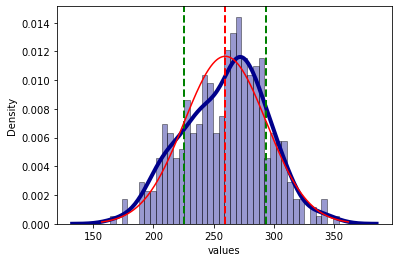

(259.75616438356167, 34.20018820064123)

In [67]:
# plot the distribution (density plot)
distribution_analysis(df2019.CMPLNT_NUM,bins=40,fit_distribution='normal')

In [68]:
# normality test
stats.shapiro(df2019.CMPLNT_NUM)#p value>0.05

ShapiroResult(statistic=0.992720365524292, pvalue=0.07309418171644211)

In [69]:
def is_normal(x): #check is the distribution is normal using one-sample KS test and sample mean-std
    return stats.kstest(x,'norm',args=(x.mean(),x.std()))

In [70]:
is_normal(df2019.CMPLNT_NUM)##p value>0.05

KstestResult(statistic=0.06047021831861077, pvalue=0.13300285852353144)

In [71]:
#p values > 0.05, the distribution may follows normal distribution

### 2. weekdays vs weekend distribution

In [72]:
# create dataframes for weekdays and weekends
weekdays=df[df['DOW']<=4]
weekends=df[df['DOW']>4]

In [73]:
# group daily numbers for weekdays and weekends
DOWdays=weekdays.groupby(['CMPLNT_FR_DT']).agg({'CMPLNT_NUM':'count','POPULATION':'sum'})
DOWends=weekends.groupby(['CMPLNT_FR_DT']).agg({'CMPLNT_NUM':'count','POPULATION':'sum'})

In [74]:
DOWdays

,CMPLNT_NUM,POPULATION
CMPLNT_FR_DT,,
2019-01-01,340,19265845.0
2019-01-02,207,11601487.0
2019-01-03,262,14651006.0
2019-01-04,266,14104118.0
2019-01-07,225,12838975.0
...,...,...
2022-12-26,231,13823545.0
2022-12-27,290,16432446.0
2022-12-28,259,13713301.0


In [75]:
#normalize by total population
POP=zips.POPULATION.sum()
DOWdays['tdensity']=DOWdays['CMPLNT_NUM']/POP*100000
DOWends['tdensity']=DOWends['CMPLNT_NUM']/POP*100000

In [76]:
DOWdays.tdensity

CMPLNT_FR_DT
2019-01-01    4.048291
2019-01-02    2.464695
2019-01-03    3.119565
2019-01-04    3.167192
2019-01-07    2.679016
                ...   
2022-12-26    2.750456
2022-12-27    3.452954
2022-12-28    3.083845
2022-12-29    3.095752
2022-12-30    3.095752
Name: tdensity, Length: 1044, dtype: float64

Mean = 3.43
Standard deviation = 0.67
1 percentile = 2.01
5 percentile = 2.40
25 percentile = 2.97
50 percentile = 3.39
75 percentile = 3.87
95 percentile = 4.50
99 percentile = 4.97


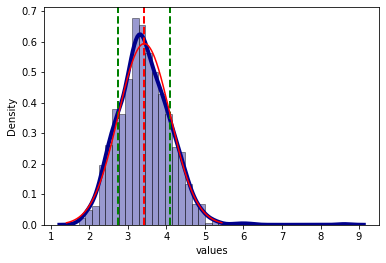

(3.4262550575089374, 0.6723562093978352)

In [77]:
# plot distribution (density plot)
distribution_analysis(DOWdays['tdensity'],fit_distribution='normal',bins=40)

Mean = 3.31
Standard deviation = 0.65
1 percentile = 1.98
5 percentile = 2.26
25 percentile = 2.85
50 percentile = 3.30
75 percentile = 3.74
95 percentile = 4.41
99 percentile = 4.75


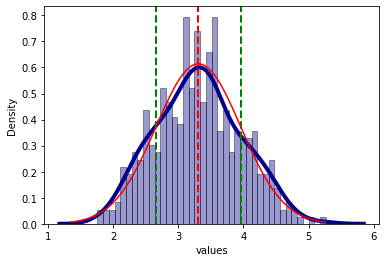

(3.3099589107271004, 0.64984694335357)

In [78]:
distribution_analysis(DOWends['tdensity'],fit_distribution='normal',bins=40)

In [79]:
#normalize by respective population
DOWdays['rdensity']=DOWdays['CMPLNT_NUM']/DOWdays['POPULATION']*100000
DOWends['rdensity']=DOWends['CMPLNT_NUM']/DOWends['POPULATION']*100000

Mean = 1.75
Standard deviation = 0.06
1 percentile = 1.61
5 percentile = 1.66
25 percentile = 1.71
50 percentile = 1.75
75 percentile = 1.79
95 percentile = 1.84
99 percentile = 1.89


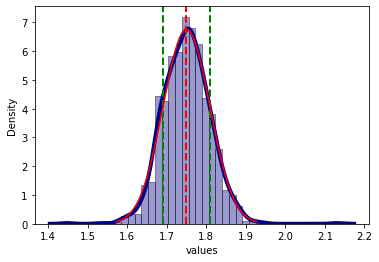

(1.7496974701604355, 0.05907991056145183)

In [80]:
distribution_analysis(DOWdays['rdensity'],fit_distribution='normal',bins=40)

Mean = 1.74
Standard deviation = 0.06
1 percentile = 1.62
5 percentile = 1.65
25 percentile = 1.70
50 percentile = 1.74
75 percentile = 1.79
95 percentile = 1.84
99 percentile = 1.87


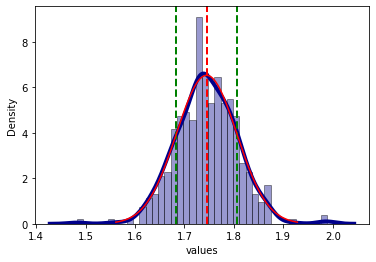

(1.7447218780680112, 0.06111398926389596)

In [81]:
distribution_analysis(DOWends['rdensity'],fit_distribution='normal',bins=40)

In [82]:
# t-test
stats.ttest_ind(DOWdays['tdensity'],DOWends['tdensity'])#reject

Ttest_indResult(statistic=3.0121792920444723, pvalue=0.0026384241773314133)

In [83]:
stats.ttest_ind(DOWdays['rdensity'],DOWends['rdensity'])#keep

Ttest_indResult(statistic=1.4384748152473863, pvalue=0.15051384638373733)

In [84]:
# k-s test
stats.ks_2samp(DOWdays['tdensity'],DOWends['tdensity'])#reject

KstestResult(statistic=0.07285206317704457, pvalue=0.07963992172262091)

In [85]:
stats.ks_2samp(DOWdays['rdensity'],DOWends['rdensity'])#keep

KstestResult(statistic=0.05485956062736018, pvalue=0.3169475446720239)

In [86]:
#if I normalized by total population of the city which test will be the same as testing crimes counts, I can reject all hypothesis at the 10% significance level

In [87]:
#if I normalized by respective population of each zipcode zone when it happens, I can not reject either hypothesis at the 10% significance level